Using device: cpu

--- Loading Data ---

--- Dataset Analysis ---
Classes Detected: ['bathroom', 'bedroom', 'dining_room', 'kitchen', 'livingroom']
Total Training Images: 2056
Total Validation Images: 517

--- Setting up ResNet50 ---

--- Starting Training (This may take a few minutes on CPU) ---

Epoch 1/5
----------
train Loss: 1.1261 Acc: 0.5696
val Loss: 0.8098 Acc: 0.6770

Epoch 2/5
----------
train Loss: 0.8640 Acc: 0.6629
val Loss: 0.6613 Acc: 0.7485

Epoch 3/5
----------
train Loss: 0.8283 Acc: 0.6824
val Loss: 0.6057 Acc: 0.7814

Epoch 4/5
----------
train Loss: 0.7686 Acc: 0.6911
val Loss: 0.6174 Acc: 0.7795

Epoch 5/5
----------
train Loss: 0.7676 Acc: 0.7101
val Loss: 0.6189 Acc: 0.7679

Training complete in 38m 34s
Best val Acc: 0.781431

--- Plotting Results ---


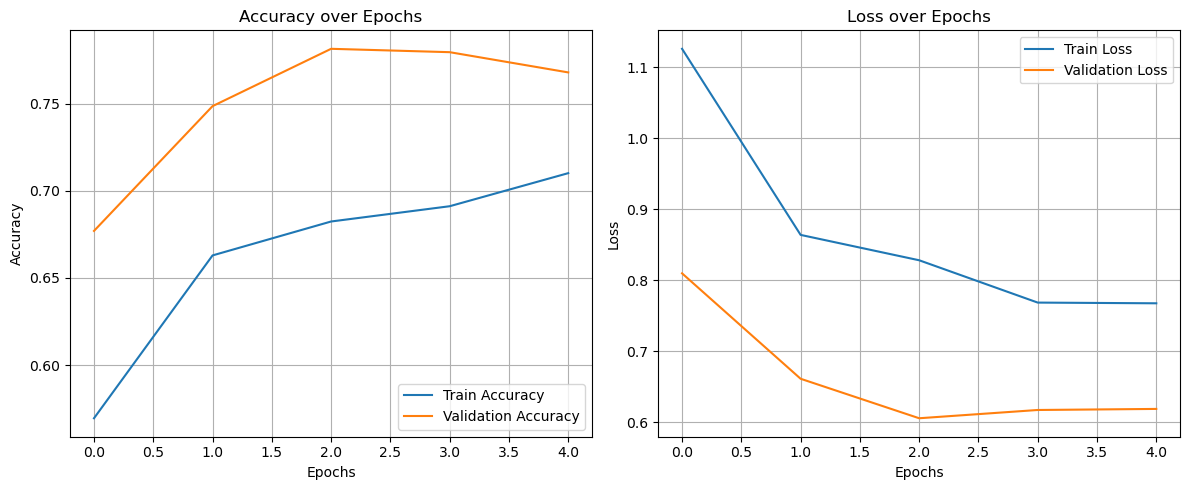


✅ Model saved to room_classifier_resnet50.pth


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import copy


DATA_ROOT =r"C:\Users\hp\Downloads\code_move\my_custom_dataset"
BATCH_SIZE = 16  # Reduced batch size for CPU (easier on RAM)
NUM_EPOCHS = 5   # Reduced epochs (CPU is slower, so we start small)
LEARNING_RATE = 0.001

# FORCE CPU
DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

# Standardize images for the model
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("\n--- Loading Data ---")
image_datasets = {}
dataloaders = {}
dataset_sizes = {}

try:
    for x in ['train', 'val']:
        path = os.path.join(DATA_ROOT, x)
        if not os.path.exists(path):
            print(f"❌ Error: Path not found: {path}")
            print("Please check your folder structure matches: my_custom_dataset/my_custom_dataset/train")
            exit()
            
        image_datasets[x] = datasets.ImageFolder(path, data_transforms[x])
        # num_workers=0 is often safer/more stable on Windows CPU
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        dataset_sizes[x] = len(image_datasets[x])

    class_names = image_datasets['train'].classes
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()

#  ANALYZE DATASET
print(f"\n--- Dataset Analysis ---")
print(f"Classes Detected: {class_names}")
print(f"Total Training Images: {dataset_sizes['train']}")
print(f"Total Validation Images: {dataset_sizes['val']}")


#  MODEL SETUP (ResNet50)
print("\n--- Setting up ResNet50 ---")

# Load pre-trained ResNet50
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers (so we don't retrain the whole brain, just the last part)
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final layer (Fully Connected) with our number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()
# Only optimize parameters of the final layer
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)

#  TRAINING LOOP
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    
    # Store history for plotting
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            # Enumerate helps track progress
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Run Training
print("\n--- Starting Training (This may take a few minutes on CPU) ---")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, num_epochs=NUM_EPOCHS)

#  PLOTTING RESULTS
print("\n--- Plotting Results ---")
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png') 
plt.show()

#  SAVE MODEL
save_path = 'room_classifier_resnet50.pth'
torch.save(model_ft.state_dict(), save_path)
print(f"\n✅ Model saved to {save_path}")

Using device: cpu
✅ Found classes from dataset: ['bathroom', 'bedroom', 'dining_room', 'kitchen', 'livingroom']
Loading model...


C:\Users\hp\AppData\Local\Temp\ipykernel_6508\4051022423.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVIC


--- 🏠 Prediction Results ---
Image: C:\Users\hp\Downloads\living.webp
Detected: livingroom
Confidence: 84.80%

--- Top Probabilities ---
1. livingroom: 84.80%
2. bedroom: 13.12%
3. dining_room: 1.09%


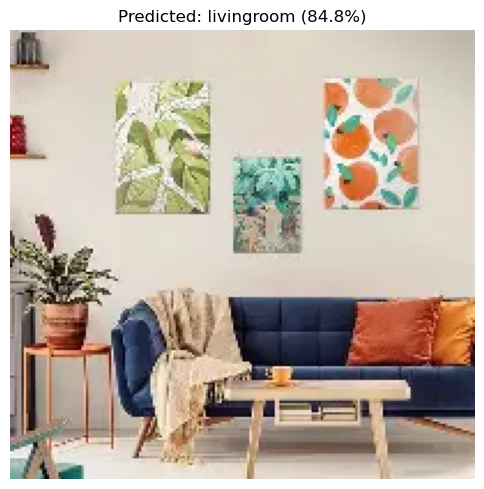

In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import torch.nn as nn
import matplotlib.pyplot as plt


MODEL_PATH =r'room_classifier_resnet50.pth'
DATA_ROOT = r"C:\Users\hp\Downloads\code_move\my_custom_dataset" # Used to get class names automatically
TEST_IMAGE_PATH =r"C:\Users\hp\Downloads\living.webp"  # Replace with the image you want to test

# Force CPU (since you trained on CPU or want to run on CPU)
DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")


#  HELPER FUNCTIONS
def get_class_names():
    """Try to infer class names from the dataset directory."""
    train_dir = os.path.join(DATA_ROOT, 'train')
    if os.path.exists(train_dir):
        # Folder names are the class names, sorted alphabetically
        classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
        print(f"✅ Found classes from dataset: {classes}")
        return classes
    else:
        print("⚠️ Dataset folder not found. Using default class list (Verify alphabetical order!).")
        # Update this list if your folders are different or you moved the model
        return ['bathroom', 'bedroom', 'dining_room', 'kitchen', 'livingroom']

def load_model(num_classes):
    """Loads the ResNet50 architecture and weights."""
    print("Loading model...")
    if not os.path.exists(MODEL_PATH):
        print(f"❌ Error: Model file '{MODEL_PATH}' not found. Run training script first.")
        return None

    # Re-initialize the model architecture (Must match training!)
    # We use weights=None because we are loading our own trained weights
    model = models.resnet50(weights=None) 
    
    # Replace the final layer to match the number of classes we trained on
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Load the trained weights
    try:
        # map_location=DEVICE ensures it loads onto CPU even if trained on GPU
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    except Exception as e:
        print(f"❌ Error loading state dict: {e}")
        return None

    model = model.to(DEVICE)
    model.eval() # Set to evaluation mode (important for BatchNormal/Dropout layers)
    return model

def preprocess_image(image_path):
    """Loads and transforms image for the model."""
    if not os.path.exists(image_path):
        print(f"❌ Error: Image '{image_path}' not found.")
        return None, None

    # Same transforms as 'val' in training
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        # Add batch dimension [1, 3, 224, 224]
        return image, transform(image).unsqueeze(0).to(DEVICE) 
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None, None


#  PREDICTION LOGIC

def predict_room(model, class_names, image_path):
    original_image, tensor = preprocess_image(image_path)
    if tensor is None: return

    with torch.no_grad():
        outputs = model(tensor)
        # Convert logits to probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted_idx.item()]
        conf_score = confidence.item() * 100

        # Display Result
        print(f"\n--- 🏠 Prediction Results ---")
        print(f"Image: {image_path}")
        print(f"Detected: {predicted_class}")
        print(f"Confidence: {conf_score:.2f}%")
        
        # Show Top 3 (useful if the model is confused)
        if len(class_names) >= 3:
            print("\n--- Top Probabilities ---")
            top_prob, top_class = torch.topk(probabilities, 3)
            for i in range(3):
                p = top_prob[0][i].item() * 100
                c = class_names[top_class[0][i].item()]
                print(f"{i+1}. {c}: {p:.2f}%")

        # Visualize
        plt.figure(figsize=(6, 6))
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({conf_score:.1f}%)")
        plt.show()

#  MAIN EXECUTION
if __name__ == "__main__":
    # 1. Get Classes
    classes = get_class_names()
    
    # 2. Load Model
    room_model = load_model(len(classes))
    
    if room_model:
        # 3. Run Prediction
        # Check if the hardcoded test image exists
        if os.path.exists(TEST_IMAGE_PATH):
            predict_room(room_model, classes, TEST_IMAGE_PATH)
        else:
            print(f"\n⚠️ Default image '{TEST_IMAGE_PATH}' not found.")
            # Interactive mode: Ask user for an image path
            user_path = input("Enter path to room image (drag and drop file here): ").strip().replace('"', '')
            if user_path:
                predict_room(room_model, classes, user_path)